✔️ Dados lidos do PostgreSQL. Total de registros: 2514

Após limpeza e interpolação de dados (sem reindexamento forçado):
                            Temp   Umi  Vento     Rad  Chuva
timestamp                                                   
2025-12-03 13:52:41.264822  25.0  80.0    3.0  100.00    0.0
2025-12-03 14:57:24.174555  17.7  97.0    2.4    0.20    0.0
2025-12-03 14:57:24.389002  17.7  98.0    2.4    0.20    0.0
2025-12-03 14:57:24.437070  17.7  97.0    2.1    0.10    0.0
2025-12-03 14:57:24.485168  17.6  98.0    2.6    0.15    0.0
Tamanho do DF após limpeza rigorosa: 2514 linhas.

Shape final do dataset de modelagem: (2489, 27)

Tamanhos:
Treino: (1991, 26)
Teste: (498, 26)
⚠️ Limpando pasta local: LinearRegression_model

===== LinearRegression =====
RMSE: 1.127012098578095
MAE: 0.8075921594858916
🏃 View run LinearRegression at: http://mlflow:5000/#/experiments/0/runs/08ddb5a9d41c4b9481eb1f0e20a9cdbf
🧪 View experiment at: http://mlflow:5000/#/experiments/0
⚠️ Limpando pasta

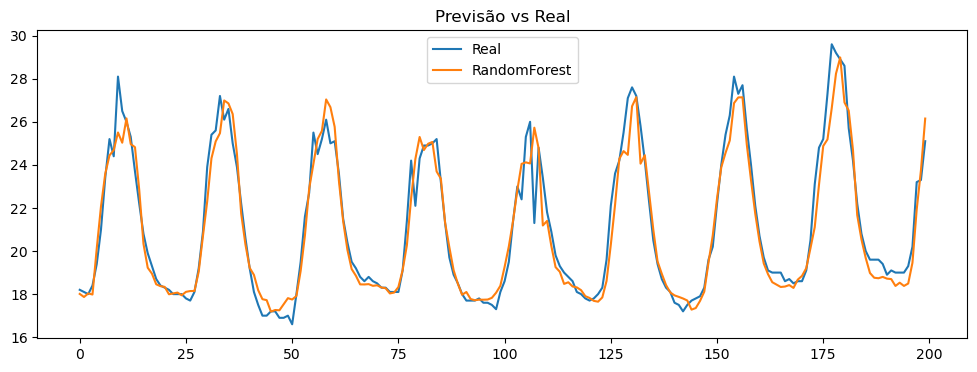

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
import os
import sqlalchemy
import shutil

DB_URL = "postgresql://admin:secret@db:5432/weather_db" 
TABLE_NAME = "weather_measurements"

try:
    engine = sqlalchemy.create_engine(DB_URL)
    df_raw = pd.read_sql(f"SELECT * FROM {TABLE_NAME} ORDER BY timestamp", engine)
    df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
    df_raw = df_raw.set_index('timestamp')
    df_raw.rename(columns={
        'temperature': 'Temp', 
        'humidity': 'Umi', 
        'wind_speed': 'Vento', 
        'radiation': 'Rad', 
        'precipitation': 'Chuva'
    }, inplace=True)
    df_raw = df_raw.loc[~df_raw.index.duplicated(keep='last')]
    
    print(f"✔️ Dados lidos do PostgreSQL. Total de registros: {len(df_raw)}")

except Exception as e:
    print(f"❌ ERRO ao conectar ou ler do PostgreSQL: {e}")
    print("Verifique se o container 'db' e 'fastapi' estão rodando.")
    if os.path.exists("data/dados_tratados.csv"):
        print("Usando fallback CSV...")
        df_raw = pd.read_csv("data/dados_tratados.csv", index_col=0, parse_dates=True)
        df_raw.columns = ['Temp', 'Umi', 'Vento', 'Rad', 'Chuva']
    else:
        raise ConnectionError("Falha crítica: Não foi possível conectar ao DB e o CSV de fallback não existe.")

df = df_raw[['Temp', 'Umi', 'Vento', 'Rad', 'Chuva']].copy()
df = df.interpolate(method="time")
df["Rad"] = df["Rad"].fillna(0)
df = df.ffill().bfill()

print("\nApós limpeza e interpolação de dados (sem reindexamento forçado):") # Alterei a mensagem para refletir a mudança
print(df.head())

if df.isnull().values.any():
    print(f"🚨 AVISO CRÍTICO: Encontrado NaNs em {df.isnull().sum().sum()} células após a limpeza.")
    df = df.fillna(0)
    print("✅ NaNs restantes preenchidos com 0 para prosseguir com a modelagem.")

print(f"Tamanho do DF após limpeza rigorosa: {len(df)} linhas.")
df_model = df.copy()

lags = [1, 2, 3, 6, 12, 24]
for lag in lags:
    df_model[f"Temp_lag_{lag}"] = df_model["Temp"].shift(lag)
    df_model[f"Umi_lag_{lag}"] = df_model["Umi"].shift(lag)
    df_model[f"Vento_lag_{lag}"] = df_model["Vento"].shift(lag)
    df_model[f"Rad_lag_{lag}"] = df_model["Rad"].shift(lag)

df_model["hour"] = df_model.index.hour
df_model["hour_sin"] = np.sin(2 * np.pi * df_model["hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["hour"] / 24)
df_model["Temp_future_1h"] = df_model["Temp"].shift(-1)
df_model.drop(columns=['Temp', 'Umi', 'Vento', 'Rad', 'Chuva', 'hour'], inplace=True)

df_model = df_model.dropna()

print("\nShape final do dataset de modelagem:", df_model.shape)
X = df_model.drop(columns=["Temp_future_1h"])
y = df_model["Temp_future_1h"]

TEST_SIZE_PERCENTAGE = 0.2
MIN_TEST_ROWS = 5

if len(X) <= (lags[-1] + MIN_TEST_ROWS):
    raise ValueError(f"Falha crítica: O dataset de modelagem está muito pequeno ({len(X)} linhas). Não é possível garantir a divisão (mínimo de {lags[-1] + MIN_TEST_ROWS + 1} linhas necessárias). Verifique a extensão dos dados no DB.")

test_size_val = TEST_SIZE_PERCENTAGE
if len(X) < 50:
    test_size_val = MIN_TEST_ROWS

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size_val, shuffle=False
)

print("\nTamanhos:")
print("Treino:", X_train.shape)
print("Teste:", X_test.shape)

def treinar_modelo(nome, modelo): 
    with mlflow.start_run(run_name=nome):
        modelo.fit(X_train, y_train)
        pred = modelo.predict(X_test)
        rmse = mean_squared_error(y_test, pred, squared=False)
        mae = mean_absolute_error(y_test, pred)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        path = f"{nome}_model"
        if os.path.exists(path):
            try:
                shutil.rmtree(path)
                print(f"⚠️ Limpando pasta local: {path}")
            except OSError as e:
                print(f"Erro ao remover a pasta {path}: {e}. Tentando salvar mesmo assim.")

        mlflow.sklearn.save_model(modelo, path)      
        mlflow.log_artifacts(path, artifact_path=nome) 
        print(f"\n===== {nome} =====")
        print("RMSE:", rmse)
        print("MAE:", mae)

        return pred

pred_lr = treinar_modelo("LinearRegression", LinearRegression())
pred_rf = treinar_modelo("RandomForest", RandomForestRegressor(
    n_estimators=200,
    random_state=42
))

plt.figure(figsize=(12,4))
plt.plot(y_test.values[:200], label="Real")
plt.plot(pred_rf[:200], label="RandomForest")
plt.legend()
plt.title("Previsão vs Real")
plt.show()

In [18]:
import shutil
import os

for pasta in ["LinearRegression_model", "RandomForest_model"]:
    if os.path.exists(pasta):
        shutil.rmtree(pasta)
        print(f"Removido: {pasta}")


Removido: LinearRegression_model
Removido: RandomForest_model
